<a href="https://colab.research.google.com/github/VuongDS/Titanic---Machine-Learning-from-Disaster/blob/main/Titanic_Machine_Learning_from_Disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -q https://raw.githubusercontent.com/VuongDS/305/main/train.csv
!wget -q image https://github.com/VuongDS/305/blob/main/Screenshot_1.png?raw=true -O images.png

In [ ]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##1. **Business Understanding**

*   **Goal**
Predict the survivor on the test set. For each in the test set, you must predict a 0 or 1 value for the variable.
*   **Metric**
The score is the percentage of passengers that  was predicted correctly. This is known as accuracy.







##2. **Data Understanding**



*   **2.1. Data Description:**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.shape

(891, 12)

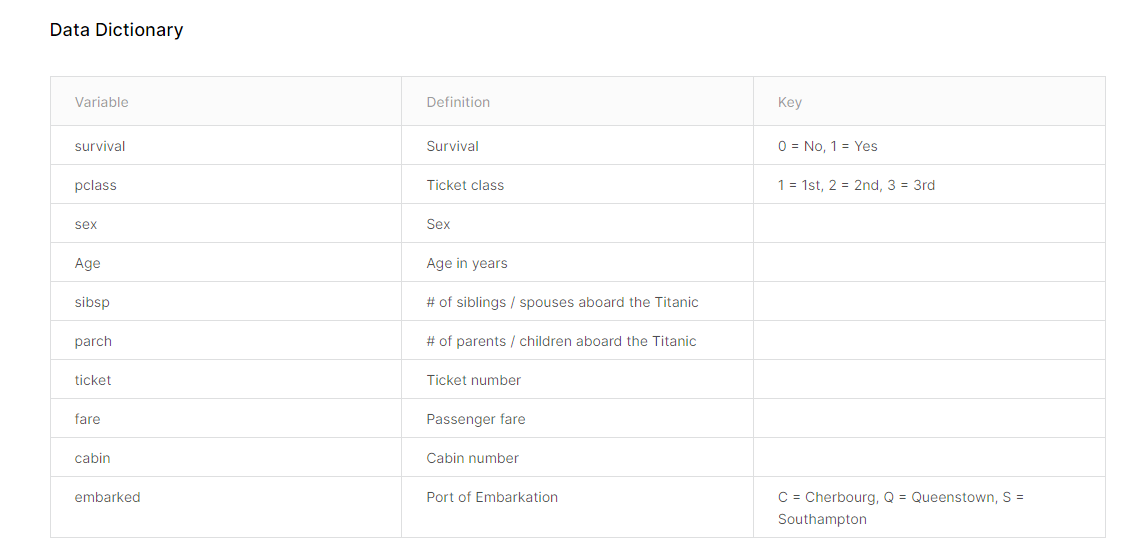

In [ ]:
from IPython.display import Image
Image('images.png')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
# remove columns name, passengerID, Ticket, Cabin
df_feature = df.drop(['PassengerId','Name', 'Ticket', 'Cabin'], axis=1)
df_feature.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [ ]:
# move position of ground truth to the last
df1 = df_feature.pop('Survived')
df_feature['Survived'] = df1

In [ ]:
df_feature.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,22.0,1,0,7.2500,S,0
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,1
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,0


In [ ]:
# the mode of  categorical value of 'Embarked'
df_feature['Embarked'].mode()

0    S
dtype: object

In [ ]:
# fill NaN value by mode value
df_feature["Embarked"].fillna('S', inplace = True)

In [ ]:
# fill NaN Age value by mean value
df_feature["Age"].fillna(df_feature['Age'].mean(), inplace = True)

In [ ]:
# check again
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    object 
 7   Survived  891 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [ ]:
# for col in df_feature.columns:
#     plt.hist(df_feature[col])
#     plt.xlabel(col)
#     plt.show()

In [ ]:
# map categorical value to int value
df_feature['Sex'] = df_feature['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

df_feature.loc[ df_feature['Age'] <= 16, 'Age'] = 0
df_feature.loc[(df_feature['Age'] > 16) & (df_feature['Age'] <= 32), 'Age'] = 1
df_feature.loc[(df_feature['Age'] > 32) & (df_feature['Age'] <= 48), 'Age'] = 2
df_feature.loc[(df_feature['Age'] > 48) & (df_feature['Age'] <= 64), 'Age'] = 3
df_feature.loc[ df_feature['Age'] > 64, 'Age'] = 4
df_feature['Age'] = df_feature['Age'].astype(int)

df_feature['Embarked'] = df_feature['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

df_feature.loc[ df_feature['Fare'] <= 7.91, 'Fare'] = 0
df_feature.loc[(df_feature['Fare'] > 7.91) & (df_feature['Fare'] <= 14.454), 'Fare'] = 1
df_feature.loc[(df_feature['Fare'] > 14.454) & (df_feature['Fare'] <= 31), 'Fare']   = 2
df_feature.loc[ df_feature['Fare'] > 31, 'Fare'] = 3
df_feature['Fare'] = df_feature['Fare'].astype(int)

df_feature.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,0,1,1,0,0,0,0
1,1,1,2,1,0,3,1,1
2,3,1,1,0,0,1,0,1
3,1,1,2,1,0,3,0,1
4,3,0,2,0,0,1,0,0


In [ ]:
# check type
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Pclass    891 non-null    int64
 1   Sex       891 non-null    int64
 2   Age       891 non-null    int64
 3   SibSp     891 non-null    int64
 4   Parch     891 non-null    int64
 5   Fare      891 non-null    int64
 6   Embarked  891 non-null    int64
 7   Survived  891 non-null    int64
dtypes: int64(8)
memory usage: 55.8 KB


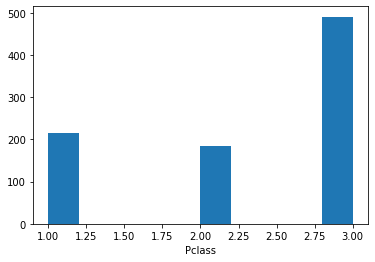

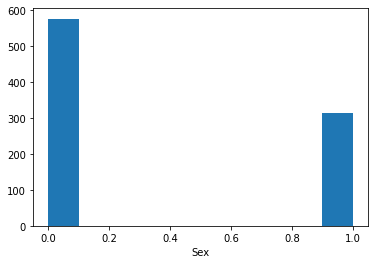

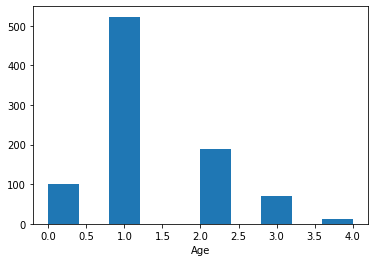

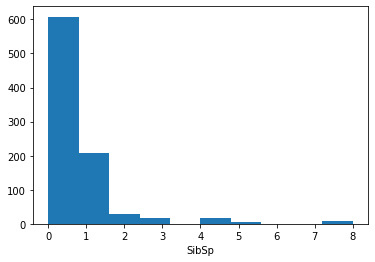

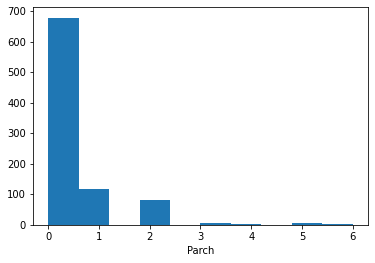

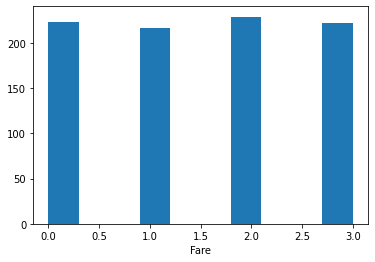

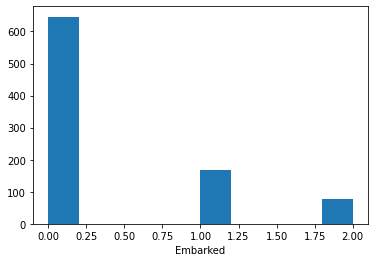

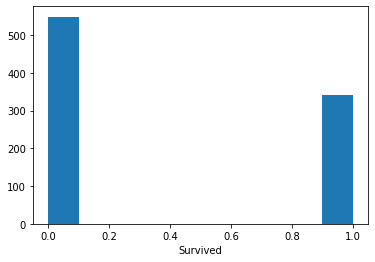

In [ ]:
for col in df_feature.columns:
    plt.hist(df_feature[col])
    plt.xlabel(col)
    plt.show()

**2.2 Exploratory Data Analysis - EDA:**







In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

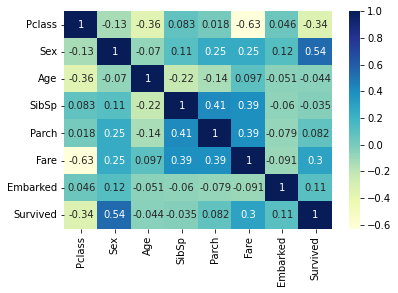

In [ ]:
dataplot = sb.heatmap(df_feature.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

In [ ]:
for col in df_feature.columns:
  if col != 'Survived':
    display(df_feature[[col, "Survived"]].groupby([col], as_index=False).mean().sort_values(by='Survived', ascending=False))

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


,Sex,Survived
1,1,0.742038
0,0,0.188908


,Age,Survived
0,0,0.550000
3,3,0.434783
2,2,0.404255
1,1,0.344168
4,4,0.090909


,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


,Fare,Survived
3,3,0.581081
2,2,0.445415
1,1,0.308756
0,0,0.197309


,Embarked,Survived
1,1,0.553571
2,2,0.389610
0,0,0.339009


##3. **Data Preparation**








In [ ]:
# Prepare X and Y for dataset
X = df_feature.drop('Survived', axis = 1)
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,1,1,0,0,0
1,1,1,2,1,0,3,1
2,3,1,1,0,0,1,0
3,1,1,2,1,0,3,0
4,3,0,2,0,0,1,0


In [ ]:
Y = df_feature[['Survived']]
Y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [ ]:
# Standardize data
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

In [ ]:
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5,6
0,0.827377,-0.737695,-0.357914,0.432793,-0.473674,-1.346777,-0.568837
1,-1.566107,1.355574,0.873365,0.432793,-0.473674,1.337738,1.005181
2,0.827377,1.355574,-0.357914,-0.474545,-0.473674,-0.451938,-0.568837
3,-1.566107,1.355574,0.873365,0.432793,-0.473674,1.337738,-0.568837
4,0.827377,-0.737695,0.873365,-0.474545,-0.473674,-0.451938,-0.568837


In [ ]:
# Use train_test_split to make X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split
import numpy as np
def train_test_split_dataset(size):
  X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=size, random_state=7)
  y_train = np.ravel(y_train)
  y_test = np.ravel(y_test)
  print ('Train set:', X_train.shape,  y_train.shape)
  print ('Test set:', X_test.shape,  y_test.shape)
  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split_dataset(0.164)

Train set: (744, 7) (744,)
Test set: (147, 7) (147,)


##4. **Modeling**







In [ ]:
# a dictionary for keeping all scores of the classifiers
accuracy = {'train':{}, 'test':{}}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# TO DO:
# Train Model and Predict

#Define random forest model
RFC = RandomForestClassifier()

#Parameter setting for GridSearchCV
params = [{'n_estimators': [100, 120], # The number of trees in the forest.
           'max_depth' : [5, 7], # The maximum depth of the tree.
         'min_samples_split': [2, 4]}] # Specifies the minimum number of samples required to split an internal node.
gs_RFC = GridSearchCV (RFC, param_grid = params, scoring='accuracy')
gs_RFC.fit(X_train, y_train)
gs_RFC.best_params_

{'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 120}

In [ ]:
best_RFC = RandomForestClassifier(max_depth = 7, min_samples_split = 2, n_estimators = 100)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_train_pred = gs_RFC.predict(X_train)
y_test_pred = gs_RFC.predict(X_test)
score_train_RFC = accuracy_score(y_train, y_train_pred)
score_test_RFC = accuracy_score(y_test, y_test_pred)

accuracy['train']['RFC'] = score_train_RFC
accuracy['test']['RFC'] = score_test_RFC


print("Train set Accuracy: ", score_train_RFC)
print("Test set Accuracy: ", score_test_RFC)

Train set Accuracy:  0.8494623655913979
Test set Accuracy:  0.7755102040816326


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#TO DO:
#Train Model and Predict

#Define k-nearest neighbors model
knn = KNeighborsClassifier()

#Parameter setting for GridSearchCV
params = [{'n_neighbors': [25, 30], # Number of neighbors to use by default for kneighbors queries.
           'leaf_size' : [2, 4], # Leaf size passed to BallTree or KDTree
         'weights': ['uniform', 'distance']}]
         # ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
         # 'distance' : in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
gs_knn = GridSearchCV (knn, param_grid = params)
gs_knn.fit(X_train, y_train)
gs_knn.best_params_

{'leaf_size': 2, 'n_neighbors': 30, 'weights': 'uniform'}

In [ ]:
best_knn = KNeighborsClassifier(leaf_size = 2, n_neighbors = 30, weights = 'uniform')

In [ ]:
y_train_pred = gs_knn.predict(X_train)
y_test_pred = gs_knn.predict(X_test)
score_train_knn = accuracy_score(y_train, y_train_pred)
score_test_knn = accuracy_score(y_test, y_test_pred)

accuracy['train']['KNN'] = score_train_knn
accuracy['test']['KNN'] = score_test_knn


print("Train set Accuracy: ", score_train_knn)
print("Test set Accuracy: ", score_test_knn)

Train set Accuracy:  0.8306451612903226
Test set Accuracy:  0.7482993197278912


In [ ]:
from sklearn.svm import SVC

In [ ]:
#TO DO:

#Define SVM model
svc = SVC()

#Parameter setting for Support Vector Machine
param_svc = {'C': [0.1, 1],  # The strength of the regularization
              'gamma': [0.1, 0.01], # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
              'random_state' : [1, 5], # random number generation
             'probability' : [True]} # Whether to enable probability estimates
gs_svc = GridSearchCV (svc, param_grid = param_svc, cv = 8) 
gs_svc.fit(X_train, y_train)
gs_svc.best_params_

{'C': 1, 'gamma': 0.1, 'probability': True, 'random_state': 1}

In [ ]:
best_svm = SVC(C = 1, gamma = 0.1, probability = True, random_state = 1)

In [ ]:
y_train_pred = gs_svc.predict(X_train)
y_test_pred = gs_svc.predict(X_test)
score_train_svc = accuracy_score(y_train, y_train_pred)
score_test_svc = accuracy_score(y_test, y_test_pred)

accuracy['train']['SVM'] = score_train_svc
accuracy['test']['SVM'] = score_test_svc


print("Train set Accuracy: ", score_train_svc)
print("Test set Accuracy: ", score_test_svc)

Train set Accuracy:  0.842741935483871
Test set Accuracy:  0.7619047619047619


In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier as LGB

In [ ]:
#Define lightgbm model
lgb = LGB()

In [ ]:
#Define lightgbm model
lgb = LGB()

#Parameter setting for Support Vector Machine
param_lgb = {'learning_rate': [0.09, 0.07, 0.05, 0.03, 0.01], 
              'max_depth': [-1, 5, 15, 20, 25, 30], # the more levels the tree has, which makes it more complex and prone to overfit, <= 0 means no limit
              'random_state' : [1, 42]}

gs_lgb = GridSearchCV (lgb, param_grid = param_lgb, cv = 8) 
gs_lgb.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          verbose=-1,eval_metric='logloss')
gs_lgb.best_params_

{'learning_rate': 0.03, 'max_depth': 5, 'random_state': 1}

In [ ]:
best_lgb = LGB(learning_rate = 0.09, max_depth = -5, random_state = 1)

In [ ]:
y_train_pred = gs_lgb.predict(X_train)
y_test_pred = gs_lgb.predict(X_test)
score_train_soft = accuracy_score(y_train, y_train_pred)
score_test_soft = accuracy_score(y_test, y_test_pred)

accuracy['test']['LGBM'] = score_test_soft
accuracy['train']['LGBM'] = score_train_soft


print("Train set Accuracy: ", score_train_soft)
print("Test set Accuracy: ", score_test_soft)

Train set Accuracy:  0.842741935483871
Test set Accuracy:  0.7959183673469388


In [ ]:
from xgboost import XGBClassifier 

In [ ]:
#Define XgBoost model
xg = XGBClassifier()

#Parameter setting for Support Vector Machine
param_xg = {'learning_rate': [0.09, 0.07, 0.05, 0.03, 0.01],  
              'max_delta_step': [0, 2, 4, 6, 8], 
              'max_depth' : [5, 15, 20, 25, 30]}
gs_xg = GridSearchCV (lgb, param_grid = param_xg, cv = 8) 
gs_xg.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          verbose=-1,eval_metric='logloss')
gs_xg.best_params_

{'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 5}

In [ ]:
best_xg = XGBClassifier(learning_rate = 0.05, max_delta_step = 2, max_depth = 10)

In [ ]:
y_train_pred = gs_xg.predict(X_train)
y_test_pred = gs_xg.predict(X_test)
score_train_soft = accuracy_score(y_train, y_train_pred)
score_test_soft = accuracy_score(y_test, y_test_pred)

accuracy['test']['XGB'] = score_test_soft
accuracy['train']['XGB'] = score_train_soft


print("Train set Accuracy: ", score_train_soft)
print("Test set Accuracy: ", score_test_soft)

Train set Accuracy:  0.842741935483871
Test set Accuracy:  0.7959183673469388


In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
def run_tuning_train_test(size1, size2, plus):
  best_soft = 0
  best_hard = 0
  for i in np.arange(size1, size2, plus):
    print(i)
    train_test_split_dataset(i)
    gs_RFC.fit(X_train, y_train)
    y_train_pred = gs_RFC.predict(X_train)
    y_test_pred = gs_RFC.predict(X_test)
    score_train = accuracy_score(y_train, y_train_pred)
    score_test = accuracy_score(y_test, y_test_pred)
    print(score_train, score_test)

    gs_knn.fit(X_train, y_train)
    y_train_pred = gs_knn.predict(X_train)
    y_test_pred = gs_knn.predict(X_test)
    score_train = accuracy_score(y_train, y_train_pred)
    score_test = accuracy_score(y_test, y_test_pred)
    print(score_train, score_test)


    gs_svc.fit(X_train, y_train)
    y_train_pred = gs_svc.predict(X_train)
    y_test_pred = gs_svc.predict(X_test)
    score_train = accuracy_score(y_train, y_train_pred)
    score_test = accuracy_score(y_test, y_test_pred)
    print(score_train, score_test)


    gs_lgb.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          verbose=-1,eval_metric='logloss')
    y_train_pred = gs_lgb.predict(X_train)
    y_test_pred = gs_lgb.predict(X_test)
    score_train = accuracy_score(y_train, y_train_pred)
    score_test = accuracy_score(y_test, y_test_pred)
    print(score_train, score_test)


    gs_xg.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          verbose=-1,eval_metric='logloss')
    y_train_pred = gs_xg.predict(X_train)
    y_test_pred = gs_xg.predict(X_test)
    score_train = accuracy_score(y_train, y_train_pred)
    score_test = accuracy_score(y_test, y_test_pred)
    print(score_train, score_test)


    #Create a list to store parameters
    # estimator_soft = []

    # estimator_soft.append(('RFC', best_RFC))
    # # estimator_soft.append(('KNN', best_knn))
    # # estimator_soft.append(('SVM', best_svm))
    # estimator_soft.append(('LGBM', best_lgb))
    # estimator_soft.append(('XGB', best_xg))

    #Voting Classifier with soft voting
    eclf_soft = VotingClassifier(estimators=estimator_soft, voting='soft').fit(X_train, y_train)
    y_train_pred = eclf_soft.predict(X_train)
    y_test_pred = eclf_soft.predict(X_test)
    score_train = accuracy_score(y_train, y_train_pred)
    score_test = accuracy_score(y_test, y_test_pred)
    print(score_train, score_test)

    if score_test > best_soft:
      best_soft = score_test
      print(best_soft, 'at',i)

    #Voting Classifier with soft voting
    eclf_soft = VotingClassifier(estimators=estimator_soft, voting='hard').fit(X_train, y_train)
    y_train_pred = eclf_soft.predict(X_train)
    y_test_pred = eclf_soft.predict(X_test)
    score_train = accuracy_score(y_train, y_train_pred)
    score_test = accuracy_score(y_test, y_test_pred)
    print(score_train, score_test)

    if score_test > best_hard:
      best_hard = score_test
      print(best_hard, 'at',i)


    print('-'*40)

In [ ]:
#TO DO:

#Soft Voting: In soft voting, the output class is the prediction based on the average of probability given to that class.

#Create a list to store parameters
estimator_soft = []

estimator_soft.append(('RFC', best_RFC))
# estimator_soft.append(('KNN', best_knn))
# estimator_soft.append(('SVM', best_svm))
# estimator_soft.append(('LGBM', best_lgb))
estimator_soft.append(('XGB', best_xg))

#Voting Classifier with soft voting
eclf_soft = VotingClassifier(estimators=estimator_soft, voting='soft').fit(X_train, y_train)

In [ ]:
y_train_pred = eclf_soft.predict(X_train)
y_test_pred = eclf_soft.predict(X_test)
score_train_soft = accuracy_score(y_train, y_train_pred)
score_test_soft = accuracy_score(y_test, y_test_pred)

accuracy['test']['EN_SOFT'] = score_test_soft
accuracy['train']['EN_SOFT'] = score_train_soft

#Use accuracy_score instead of Jaccard because of new version scikit learn
print("Train set Accuracy: ", score_train_soft)
print("Test set Accuracy: ", score_test_soft)

Train set Accuracy:  0.8696236559139785
Test set Accuracy:  0.7891156462585034


##5. **Results**

In [ ]:
# Report
report = pd.DataFrame(accuracy)
report.rename(columns={"train": "train_accuracy", "test": "test_accuracy"}, inplace = True)
report = report.reset_index()
report = report.rename(columns={"index": "Algorithm"})
report.set_index('Algorithm', inplace = True)
report

,train_accuracy,test_accuracy
Algorithm,,
RFC,0.849462,0.775510
KNN,0.830645,0.748299
SVM,0.842742,0.761905
LGBM,0.842742,0.795918
XGB,0.842742,0.795918
EN_SOFT,0.869624,0.789116
